In [ ]:
#@title Importation of multiple libraries
import urllib

from time import perf_counter
!pip install scikit-optimize
from scipy.optimize import minimize, minimize_scalar
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.plots import plot_objective
from skopt.plots import partial_dependence

from itertools import product
from collections import defaultdict

!pip install sparse
import sparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, combinations, product

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import time
from numpy.polynomial import polyutils as pu
from numpy.random import default_rng
from scipy.stats import ortho_group
import scipy

from scipy.linalg import svd
from sklearn.metrics import confusion_matrix

In [2]:
#Bin attributes or output values by equal sized bins in terms of marginal probability, using percentiles
#Used only for the protected attribute 'age'
#This is used only to discretize continuous attributes so that each bin is roughly of the same size

def bin_df_sens(A,n_attributes_bins=2):
    attributes_bins=np.linspace(0,1,n_attributes_bins+1)
    A_b=A.copy()
  
    for col in A.columns:
        percentiles=np.percentile(A.loc[:,col],attributes_bins*100)

        if len(np.unique(percentiles))!=len(percentiles):
            percentiles[0]=-1  
            percentiles=refine_duplicates_perc(A.loc[:,col],percentiles)  

        A_b.loc[:,col]=pd.cut(A.loc[:,col],percentiles,labels=percentiles[1:].round(3),include_lowest=True)

    return A_b

In [3]:
#Functions used to group multiples attributes together and use partitions

#For a given probability tensor and partition 
#this function group together the relevant sensitive attributes by flattening the axes of the probability tensor array
#that belong to the newly defined marginal
def packing_attributes(joint_probability_tensor,attributes_to_pack):
    #This makes the axis that we want to group together next to each other
    reordered_axes=[elem for pack in attributes_to_pack for elem in pack]
    source_axes=np.arange(joint_probability_tensor.ndim)
    destination_axes=source_axes.copy()
    destination_axes[reordered_axes]=source_axes
    #Move axis together before flattening trhough reshape
    #Necessary if we have a tensor of ndim=3, and we would like to flatten together axis 1 and 3
    #If we don't group the axis together before that, reshape won't be able to do the desired process
    res=np.moveaxis(joint_probability_tensor,source_axes,destination_axes)
    #Here we want to get the new shape of the packed array
    new_shape=[np.product(np.array(joint_probability_tensor.shape)[pack]) for pack in attributes_to_pack]
    return res.reshape(tuple(new_shape))

In [14]:
#Partition finder algorithm, and computation of relevant statistical quantities

#We adopt the following notation for our variables :
# p correspond to a probability distribution
# pj joint law of A
# pp product of marginals of A
# pjz joint law of A and Y
# pj_z joint law of A conditionally on Y
# pz_j law of Y conditionally on A 
# pp_z product of marginals A conditionally on Y
# pm marginal distributions of A
# pz_m law of Y conditionally on a marginal of A
# pm_z law of a marginal of A conditionally on Y

def compute_s_star(A_input,predictions,part):

    A=np.array(A_input)

    n_packs=len(part) 

    #Compute the probability tensor array of A in a sparse way 
    pj=defaultdict(int)
    for a in A:
        pj[tuple(a)]+=1
    pj=sparse.COO(pj)/len(A)

    #We flatten together the axis of a same set in the partition
    pj_shape=pj.shape
    pj=packing_attributes(pj,part)

    ind_pj_nonzero=pj.nonzero()

    #Compute marginal probabilities
    pm=[]
    all_axes=np.arange(n_packs)
    for i in range(n_packs):
        pm.append(pj.sum(axis=np.delete(all_axes,i)).todense())

    #Compute the product of the marginals of A_k
    pp=defaultdict(lambda:1)
    for ind in np.array(ind_pj_nonzero).T.tolist():
        for i in range(n_packs):
            pp[tuple(ind)]*=pm[i][ind[i]]
    pp=sparse.COO(pp)

    pj_nonzero=pj[ind_pj_nonzero].todense()
    pp_nonzero=pp[ind_pj_nonzero].todense()

    mu=np.sum(pj_nonzero*np.log(pj_nonzero/pp_nonzero))
    sigma=np.sqrt(np.sum(pj_nonzero*np.power(np.log(pj_nonzero/pp_nonzero)-mu,2)))

    pz_list=[]
    pj_z_list=[]
    pp_z_list=[]

    mu_z=0

    for i in range(len(np.unique(predictions))):

        z=np.unique(predictions)[i]
        pz=(predictions==z).sum()/len(predictions)
        
        A_z=A[predictions==z]
        
        #Compute joint probability A conditionally on Z
        pj_z=defaultdict(int)
        for a in np.array(A_z):
            pj_z[tuple(a)]+=1
        pj_z=(sparse.COO(pj_z,shape=pj_shape))/(len(A_z))
        pj_z=packing_attributes(pj_z,part)

        ind_pj_z_nonzero=pj_z.nonzero()

        #Compute marginal probabilities A_k conditionally on z
        pm_z=[]
        all_axes=np.arange(n_packs)
        for i in range(n_packs):
            pm_z.append(pj_z.sum(axis=np.delete(all_axes,i)).todense())
        
        #Compute the product of the marginals of A_k conditionally on Z
        pp_z=defaultdict(lambda:1)
        for ind in np.array(ind_pj_nonzero).T.tolist():
            for i in range(n_packs):
                pp_z[tuple(ind)]*=pm_z[i][ind[i]]
        pp_z=sparse.COO(pp_z)
        
        #Only consider the nonzero elements of pj as the if pj=0, then pj log(pj)=0 and they still don't count
        pj_z_nonzero=pj_z[ind_pj_z_nonzero].todense()
        pp_z_nonzero=pp_z[ind_pj_z_nonzero].todense()

        mu_z+=pz*np.sum(pj_z_nonzero*np.log(pj_z_nonzero/pp_z_nonzero))

        pz_list.append(pz)
        pj_z_list.append(pj_z_nonzero)
        pp_z_list.append(pp_z_nonzero)

    sigma_z=0

    for i in range(len(np.unique(predictions))):

        sigma_z+=pz*np.sum(pj_z_list[i]*np.power(np.log(pj_z_list[i]/pp_z_list[i])-mu_z,2))
    sigma_z=np.sqrt(sigma_z)

    s_star=np.power(np.power(sigma,2/3)+np.power(sigma_z,2/3),3/2)

    return s_star

def greedy_part(A_input,predictions,min_ng_marg):

    A=pd.DataFrame(A_input)

    unique_vals=np.unique(predictions)

    existing_groups=A.groupby(list(A.columns.values)).size().reset_index(name='Count').loc[:,'Count']

    if len(existing_groups)==A.nunique().product() and existing_groups.min()>=min_ng_marg:
        print("Enough data to directly compute full intersectional")
        return [[var for var in range(A.shape[1])]]

    part_start=[[var] for var in range(A.shape[1])]
    cur_part=part_start

    dic_enough_data_subset={}

    best_part=part_start

    #We will always keep track if we were able to merge further a partition, if it is possible we keep on looping
    any_coarser_part=True

    while any_coarser_part:

        min_s_star=np.inf

        any_coarser_part=False

        for s1,s2 in combinations(cur_part,2):

            new_part=cur_part.copy()
            new_part.remove(s1)
            new_part.remove(s2)
            new_part.append(s1+s2)

            enough_data=True

            for g_vars in new_part:
                
                #We verify that there is enough data on each marginal A_t defined by the partition part
                    
                if frozenset(g_vars) in dic_enough_data_subset:
                    enough_data=dic_enough_data_subset[frozenset(g_vars)]
                else:  
                    for z in unique_vals:
                        A_z=A.loc[predictions==z]   
                                    
                        existing_groups=A_z.groupby(list(A.columns[list(g_vars)])).size().reset_index(name='Count').loc[:,'Count']
                        g_vars_enough_data=(len(existing_groups)==np.product(A.iloc[:,list(g_vars)].nunique())) and (existing_groups.min()>=min_ng_marg)
                        enough_data=(enough_data) and (g_vars_enough_data)
                    dic_enough_data_subset[frozenset(g_vars)]=enough_data
            if enough_data:

                any_coarser_part=True

                s_star=compute_s_star(A,predictions,new_part)

                if s_star<min_s_star:
                    
                    min_s_star=s_star
                    best_part=new_part

        cur_part=best_part

    return best_part

def intersectional_unfairness(A_input,predictions,alpha=0):
    
    #This function and the followings are similar to "compute_s_star"
    #The main part is computing the joint densities and the correct "grouped" new marginal densities
    #The difference is the use of these densities to compute the various useful statistical quantities

    A=np.array(A_input)
    
    pj=defaultdict(int)
    for a in np.array(A):
        pj[tuple(a)]+=1
    pj=sparse.COO(pj).todense()+alpha
    pj=(pj+len(np.unique(predictions))*alpha)/(len(A)+len(np.unique(predictions))*np.product(pj.shape)*alpha)

    ufi_z=[]

    for i in range(len(np.unique(predictions))):

        z=np.unique(predictions)[i]
        pz=(predictions==z).sum()/len(predictions)
        
        A_z=A[predictions==z]

        pj_z=defaultdict(int)
        for a in np.array(A_z):
            pj_z[tuple(a)]+=1
        pj_z=(sparse.COO(pj_z,shape=pj.shape).todense()+alpha)/(len(A_z)+np.product(pj.shape)*alpha)

        pz_j=pz*pj_z/pj

        ufi_z.append(np.log(np.max(pz_j)/np.min(pz_j)))

    return np.max(ufi_z)

def ufi_ind_func(A_input,predictions,part,alpha=0):

    if len(part)==1:
        return intersectional_unfairness(A_input,predictions,alpha=0)

    A=np.array(A_input)

    n_packs=len(part) 

    #Compute the probability tensor array of A in a sparse way 
    pj=defaultdict(int)
    for a in A:
        pj[tuple(a)]+=1
    pj=sparse.COO(pj)/len(A)

    #We flatten together the axis of a same set in the partition
    pj_shape=pj.shape
    pj=packing_attributes(pj,part)

    ind_pj_nonzero=pj.nonzero()

    #Compute marginal probabilities
    pm=[]
    all_axes=np.arange(n_packs)
    for i in range(n_packs):
        pm.append(pj.sum(axis=np.delete(all_axes,i)).todense())

    #Compute the product of the marginals of A_k
    pp=defaultdict(lambda:1)
    for ind in np.array(ind_pj_nonzero).T.tolist():
        for i in range(n_packs):
            pp[tuple(ind)]*=pm[i][ind[i]]
    pp=sparse.COO(pp)

    pj_nonzero=pj[ind_pj_nonzero].todense()
    pp_nonzero=pp[ind_pj_nonzero].todense()

    pz_list=[]
    pj_z_list=[]
    pp_z_list=[]

    ufi_z=[]

    for i in range(len(np.unique(predictions))):

        z=np.unique(predictions)[i]
        pz=(predictions==z).sum()/len(predictions)

        A_z=A[predictions==z]
        
        #Compute joint probability A conditionally on Z
        pj_z=defaultdict(int)
        for a in np.array(A_z):
            pj_z[tuple(a)]+=1
        pj_z=(sparse.COO(pj_z,shape=pj_shape))/(len(A_z))
        pj_z=packing_attributes(pj_z,part)

        ind_pj_z_nonzero=pj_z.nonzero()

        #Compute marginal probabilities A_k conditionally on z
        pm_z=[]
        all_axes=np.arange(n_packs)
        for i in range(n_packs):
            pm_z.append(pj_z.sum(axis=np.delete(all_axes,i)).todense())
        
        
        #Compute the product of the marginals of A_k conditionally on Z
        pp_z=defaultdict(lambda:1)
        for ind in np.array(ind_pj_nonzero).T.tolist():
            for i in range(n_packs):
                pp_z[tuple(ind)]*=pm_z[i][ind[i]]
        pp_z=sparse.COO(pp_z)
        
        #Only consider the nonzero elements of pj as the if pj=0, then pj log(pj)=0 and they still don't count
        pj_z_nonzero=pj_z[ind_pj_z_nonzero].todense()
        pp_z_nonzero=pp_z[ind_pj_z_nonzero].todense()

        pz_list.append(pz)
        pj_z_list.append(pj_z_nonzero)
        pp_z_list.append(pp_z_nonzero)

        pz_m=[]
        for i in range(n_packs):
            if alpha!=0:
                pz_m.append((len(pm[i])*len(A)*pz*pm_z[i]+np.product(pj.shape)*alpha)/(len(pm[i])*len(A)*pm[i]+len(np.unique(predictions))*np.product(pj.shape)*alpha))
            else:    
                pz_m.append(pz*pm_z[i]/pm[i])

        ufm_log_i=[]
        for i in range(n_packs):
            ufm_log_i.append(np.abs(np.log(np.max(pz_m[i])/np.min(pz_m[i]))))

        ufi_z.append(np.sum(ufm_log_i))
    
    return np.max(ufi_z)

def intersectional_unfairness_quantile(A_input,predictions,delta,alpha=0):

    A=np.array(A_input)

    pj=defaultdict(int)
    for a in np.array(A):
        pj[tuple(a)]+=1
    pj=sparse.COO(pj).todense()+alpha
    pj=pj/(len(A)+np.product(pj.shape)*alpha)

    ufi_z=[]

    u_list=[]
    w_list=[]

    for i in range(len(np.unique(predictions))):

        z=np.unique(predictions)[i]
        pz=(predictions==z).sum()/len(predictions)

        A_z=A[predictions==z]

        pj_z=defaultdict(int)
        for a in np.array(A_z):
            pj_z[tuple(a)]+=1
        pj_z=(sparse.COO(pj_z,shape=pj.shape).todense()+alpha)/(len(A_z)+np.product(pj.shape)*alpha)

        pz_j=pz*pj_z/pj

        u_list.append(np.abs(np.log(np.outer(pz_j,1/pz_j))).flatten())
        w_list.append((pz*np.outer((pj_z).flatten(),(pj_z).flatten())).flatten())
    
    #Unfairness vector associated to (a,a',y)
    u_vec=np.array(u_list).flatten()
    #Probability vector associated to (a,a',y)
    w_vec=np.array(w_list).flatten()
    #We sort them by their unfairness values to compute the quantile
    u_quantile=np.sort(u_vec)[np.argmax(np.cumsum(w_vec[np.argsort(u_vec)])>1-delta)]
    
    return u_quantile

In [46]:
def compute_chernoff_bound(A_input,predictions,part,delta,return_bound=False):
    
    A=np.array(A_input)
    n_packs=len(part) 

    #Compute the probability tensor array of A in a sparse way 
    pj=defaultdict(int)
    for a in A:
        pj[tuple(a)]+=1
    pj=sparse.COO(pj)/len(A)

    #We flatten together the axis of a same set in the partition
    pj_shape=pj.shape
    pj=packing_attributes(pj,part)

    ind_pj_nonzero=pj.nonzero()

    #Compute marginal probabilities
    pm=[]
    all_axes=np.arange(n_packs)
    for i in range(n_packs):
        pm.append(pj.sum(axis=np.delete(all_axes,i)).todense())

    #Compute the product of the marginals of A_k
    pp=defaultdict(lambda:1)
    for ind in np.array(ind_pj_nonzero).T.tolist():
        for i in range(n_packs):
            pp[tuple(ind)]*=pm[i][ind[i]]
    pp=sparse.COO(pp)

    pj_nonzero=pj[ind_pj_nonzero].todense()
    pp_nonzero=pp[ind_pj_nonzero].todense()
        
    mu=np.sum(pj_nonzero*np.log(pj_nonzero/pp_nonzero))    
        
    mu_z=0
    pj_z_list=[]
    pjz_list=[]
    pz_list=[]
    pp_z_list=[]
    
    ufi_z=[]

    for i in range(len(np.unique(predictions))):

        z=np.unique(predictions)[i]
        pz=(predictions==z).sum()/len(predictions)

        A_z=A[predictions==z]

        #Compute joint probability A conditionally on Z
        pj_z=defaultdict(int)
        for a in np.array(A_z):
            pj_z[tuple(a)]+=1
        pj_z=(sparse.COO(pj_z,shape=pj_shape))/(len(A_z))
        pj_z=packing_attributes(pj_z,part)

        ind_pj_z_nonzero=pj_z.nonzero()

        #Compute marginal probabilities A_k conditionally on z
        pm_z=[]
        all_axes=np.arange(n_packs)
        for i in range(n_packs):
            pm_z.append(pj_z.sum(axis=np.delete(all_axes,i)).todense())

        #Compute the product of the marginals of A_k conditionally on Z
        pp_z=defaultdict(lambda:1)
        for ind in np.array(ind_pj_nonzero).T.tolist():
            for i in range(n_packs):
                pp_z[tuple(ind)]*=pm_z[i][ind[i]]
        pp_z=sparse.COO(pp_z)

        #Only consider the nonzero elements of pj as the if pj=0, then pj log(pj)=0 and they still don't count
        pj_z_nonzero=pj_z[ind_pj_z_nonzero].todense()
        pp_z_nonzero=pp_z[ind_pj_z_nonzero].todense()

        mu_z+=pz*np.sum(pj_z_nonzero*np.log(pj_z_nonzero/pp_z_nonzero))

        pz_list.append(pz)
        pj_z_list.append(pj_z_nonzero)
        pp_z_list.append(pp_z_nonzero)
        pjz_list.append(pj_z_nonzero*pz)
        
        if return_bound:
            
            pz_m=[]
            for i in range(n_packs):
                if alpha!=0:
                    pz_m.append((len(pm[i])*len(A)*pz*pm_z[i]+np.product(pj.shape)*alpha)/(len(pm[i])*len(A)*pm[i]+len(np.unique(predictions))*np.product(pj.shape)*alpha))
                else:    
                    pz_m.append(pz*pm_z[i]/pm[i])
        
            ufm_log_i=[]
            for i in range(n_packs):
                ufm_log_i.append(np.abs(np.log(np.power(pz,1-1/n_packs)/np.min(pz_m[i]))))

            ufi_z.append(np.sum(ufm_log_i))

    pjz=np.concatenate(pjz_list)
    pj_z=np.concatenate(pj_z_list)
    pp_z=np.concatenate(pp_z_list)
    
    
    #Computation of the cumulant generating function and their cramer transform
    def kappa_z(t):
        return np.log(np.sum(pjz*np.power(pj_z/pp_z,t)))
    
    def kappa(t):
        return np.log(np.sum(pj_nonzero*np.power(pj_nonzero/pp_nonzero,t)))
    
    def I_plus(x):
        return minimize(lambda t: kappa_z(t)-t*x, x0=0,bounds=[(0,None)]).fun

    def I_minus(x):
        return minimize(lambda t: kappa(t)-t*x, x0=0,bounds=[(None,0)]).fun

    def g_cons(x):
        return delta-2*np.exp(I_plus(x[0]))-2*np.exp(I_minus(x[1]))
    
    #Computation of the minimization problem
    chernoff_term=minimize(lambda x: x[0]-x[1],x0=(mu_z+1,mu-1),bounds=[(mu_z,None),(None,mu)],constraints=({"type":"ineq","fun":g_cons})).fun
    
    if return_bound:
        res=chernoff_term+np.max(ufi_z)
    else:
        res=chernoff_term
    
    return res

def compute_chebyshev_bound_1(A_input,predictions,part,delta,alpha=0):
    
    if len(part)==1:
        return intersectional_unfairness(A_input,predictions,alpha=0)

    A=np.array(A_input)

    n_packs=len(part) 

    #Compute the probability tensor array of A in a sparse way 
    pj=defaultdict(int)
    for a in A:
        pj[tuple(a)]+=1
    pj=sparse.COO(pj)/len(A)

    #We flatten together the axis of a same set in the partition
    pj_shape=pj.shape
    pj=packing_attributes(pj,part)

    ind_pj_nonzero=pj.nonzero()

    #Compute marginal probabilities
    pm=[]
    all_axes=np.arange(n_packs)
    for i in range(n_packs):
        pm.append(pj.sum(axis=np.delete(all_axes,i)).todense())

    #Compute the product of the marginals of A_k
    pp=defaultdict(lambda:1)
    for ind in np.array(ind_pj_nonzero).T.tolist():
        for i in range(n_packs):
            pp[tuple(ind)]*=pm[i][ind[i]]
    pp=sparse.COO(pp)

    pj_nonzero=pj[ind_pj_nonzero].todense()
    pp_nonzero=pp[ind_pj_nonzero].todense()

    mu=np.sum(pj_nonzero*np.log(pj_nonzero/pp_nonzero))
    sigma=np.sqrt(np.sum(pj_nonzero*np.power(np.log(pj_nonzero/pp_nonzero)-mu,2)))

    pz_list=[]
    pj_z_list=[]
    pp_z_list=[]

    mu_z=0

    ufi_z=[]

    for i in range(len(np.unique(predictions))):

        z=np.unique(predictions)[i]
        pz=(predictions==z).sum()/len(predictions)

        A_z=A[predictions==z]
        
        #Compute joint probability A conditionally on Z
        pj_z=defaultdict(int)
        for a in np.array(A_z):
            pj_z[tuple(a)]+=1
        pj_z=(sparse.COO(pj_z,shape=pj_shape))/(len(A_z))
        pj_z=packing_attributes(pj_z,part)

        ind_pj_z_nonzero=pj_z.nonzero()

        #Compute marginal probabilities A_k conditionally on z
        pm_z=[]
        all_axes=np.arange(n_packs)
        for i in range(n_packs):
            pm_z.append(pj_z.sum(axis=np.delete(all_axes,i)).todense())
        
        
        #Compute the product of the marginals of A_k conditionally on Z
        pp_z=defaultdict(lambda:1)
        for ind in np.array(ind_pj_nonzero).T.tolist():
            for i in range(n_packs):
                pp_z[tuple(ind)]*=pm_z[i][ind[i]]
        pp_z=sparse.COO(pp_z)
        
        #Only consider the nonzero elements of pj as the if pj=0, then pj log(pj)=0 and they still don't count
        pj_z_nonzero=pj_z[ind_pj_z_nonzero].todense()
        pp_z_nonzero=pp_z[ind_pj_z_nonzero].todense()

        mu_z+=pz*np.sum(pj_z_nonzero*np.log(pj_z_nonzero/pp_z_nonzero))

        pz_list.append(pz)
        pj_z_list.append(pj_z_nonzero)
        pp_z_list.append(pp_z_nonzero)

        pz_m=[]
        for i in range(n_packs):
            if alpha!=0:
                pz_m.append((len(pm[i])*len(A)*pz*pm_z[i]+np.product(pj.shape)*alpha)/(len(pm[i])*len(A)*pm[i]+len(np.unique(predictions))*np.product(pj.shape)*alpha))
            else:    
                pz_m.append(pz*pm_z[i]/pm[i])

        ufm_log_i=[]
        for i in range(n_packs):
            ufm_log_i.append(np.abs(np.log(np.max(pz_m[i])/np.min(pz_m[i]))))

        ufi_z.append(np.sum(ufm_log_i))
        
    sigma_z=0

    for i in range(len(np.unique(predictions))):

        sigma_z+=pz*np.sum(pj_z_list[i]*np.power(np.log(pj_z_list[i]/pp_z_list[i])-mu_z,2))
    sigma_z=np.sqrt(sigma_z)

    s_star=np.power(np.power(sigma,2/3)+np.power(sigma_z,2/3),3/2)
    
    return 2*np.sqrt(2)*s_star/np.sqrt(delta)+np.max(ufi_z) 

def compute_chebyshev_bound_2(A_input,predictions,part,delta,alpha=0):

    if len(part)==1:
        return intersectional_unfairness(A_input,predictions,alpha=0)

    A=np.array(A_input)

    n_packs=len(part) 

    #Compute the probability tensor array of A in a sparse way 
    pj=defaultdict(int)
    for a in A:
        pj[tuple(a)]+=1
    pj=sparse.COO(pj)/len(A)

    #We flatten together the axis of a same set in the partition
    pj_shape=pj.shape
    pj=packing_attributes(pj,part)

    ind_pj_nonzero=pj.nonzero()

    #Compute marginal probabilities
    pm=[]
    all_axes=np.arange(n_packs)
    for i in range(n_packs):
        pm.append(pj.sum(axis=np.delete(all_axes,i)).todense())

    #Compute the product of the marginals of A_k
    pp=defaultdict(lambda:1)
    for ind in np.array(ind_pj_nonzero).T.tolist():
        for i in range(n_packs):
            pp[tuple(ind)]*=pm[i][ind[i]]
    pp=sparse.COO(pp)

    pj_nonzero=pj[ind_pj_nonzero].todense()
    pp_nonzero=pp[ind_pj_nonzero].todense()

    mu=np.sum(pj_nonzero*np.log(pj_nonzero/pp_nonzero))
    sigma=np.sqrt(np.sum(pj_nonzero*np.power(np.log(pj_nonzero/pp_nonzero)-mu,2)))

    pz_list=[]
    pj_z_list=[]
    pp_z_list=[]

    mu_z=0

    ufi_z=[]

    for i in range(len(np.unique(predictions))):

        z=np.unique(predictions)[i]
        pz=(predictions==z).sum()/len(predictions)

        A_z=A[predictions==z]
        
        #Compute joint probability A conditionally on Z
        pj_z=defaultdict(int)
        for a in np.array(A_z):
            pj_z[tuple(a)]+=1
        pj_z=(sparse.COO(pj_z,shape=pj_shape))/(len(A_z))
        pj_z=packing_attributes(pj_z,part)

        ind_pj_z_nonzero=pj_z.nonzero()

        #Compute marginal probabilities A_k conditionally on z
        pm_z=[]
        all_axes=np.arange(n_packs)
        for i in range(n_packs):
            pm_z.append(pj_z.sum(axis=np.delete(all_axes,i)).todense())
        
        
        #Compute the product of the marginals of A_k conditionally on Z
        pp_z=defaultdict(lambda:1)
        for ind in np.array(ind_pj_nonzero).T.tolist():
            for i in range(n_packs):
                pp_z[tuple(ind)]*=pm_z[i][ind[i]]
        pp_z=sparse.COO(pp_z)
        
        #Only consider the nonzero elements of pj as the if pj=0, then pj log(pj)=0 and they still don't count
        pj_z_nonzero=pj_z[ind_pj_z_nonzero].todense()
        pp_z_nonzero=pp_z[ind_pj_z_nonzero].todense()

        mu_z+=pz*np.sum(pj_z_nonzero*np.log(pj_z_nonzero/pp_z_nonzero))

        pz_list.append(pz)
        pj_z_list.append(pj_z_nonzero)
        pp_z_list.append(pp_z_nonzero)

        pz_m=[]
        for i in range(n_packs):
            if alpha!=0:
                pz_m.append((len(pm[i])*len(A)*pz*pm_z[i]+np.product(pj.shape)*alpha)/(len(pm[i])*len(A)*pm[i]+len(np.unique(predictions))*np.product(pj.shape)*alpha))
            else:    
                pz_m.append(pz*pm_z[i]/pm[i])

        ufm_log_i=[]
        for i in range(n_packs):
            ufm_log_i.append(np.abs(np.log(np.power(pz,1-1/n_packs)/np.min(pz_m[i]))))

        ufi_z.append(np.sum(ufm_log_i))
        
    sigma_z=0

    for i in range(len(np.unique(predictions))):

        sigma_z+=pz*np.sum(pj_z_list[i]*np.power(np.log(pj_z_list[i]/pp_z_list[i])-mu_z,2))
    sigma_z=np.sqrt(sigma_z)

    s_star=np.power(np.power(sigma,2/3)+np.power(sigma_z,2/3),3/2)
    
    gamma=mu-mu_z
    
    return np.sqrt(2)*s_star/np.sqrt(delta)+gamma+np.max(ufi_z) 

# Loading the data

In [7]:
url=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt")

In [8]:
url=url.loc[url.dPoverty!=0]
Y_df=(url.dPoverty==1).astype("int32")
X_df=url.drop(columns=['dPoverty','dIncome1',
       'dIncome2', 'dIncome3', 'dIncome4', 'dIncome5', 'dIncome6', 'dIncome7',
       'dIncome8','dRearning'])

A_df=url.loc[:,['iSex','dAge']]
#We group some values of the protected attributes together to have enough data
A_df.rename(columns={'iSex':'sex','dAge':'age'},inplace=True)
A_df.loc[:,'no_work_last_yr']=url.iWork89.isin([0,2]).astype("int32")
A_df.loc[:,'in_school']=url.iSchool.isin([1,2]).astype("int32")
A_df.loc[:,'work_for_private']=url.iClass.isin([1]).astype("int32")
A_df.loc[:,'spouse_present']=url.iRspouse.isin([1]).astype("int32")
A_df.loc[:,'diff_lang_home']=url.iLang1.isin([1]).astype("int32")
A_df.loc[:,'looking_for_job']=url.iLooking.isin([1]).astype("int32")
A_df.loc[:,'not_with_spouse_anymore']=url.iMarital.isin([1,2,3]).astype("int32")
A_df.loc[:,'with_military']=url.iMilitary.isin([1,2,3]).astype("int32")
A_df.loc[:,'with_disability']=url.iDisabl1.isin([1]).astype("int32")
A_df.loc[:,'more_one_child']=url.iFertil.isin([i for i in range(2,15)]).astype("int32")
A_df.loc[:,'born_in_state_res']=url.dPOB.isin([0]).astype("int32")
A_df.loc[:,'here_for_five_years']=url.iMobility.isin([1]).astype("int32")
A_df.loc[:,'far_from_work']=url.dTravtime.isin([3,4,5,6]).astype("int32")
A_df.loc[:,'overweight']=url.dPwgt1.isin([2,3]).astype("int32")
A_df.loc[:,'no_income']=url.dIncome1.isin([0]).astype("int32")
A_df.loc[:,'own_child']=url.iRownchld.isin([1]).astype("int32")
A_df.loc[:,'related_child']=url.iRrelchld.isin([1]).astype("int32")
A_df.age=bin_df_sens(pd.DataFrame({"age":A_df.age}),n_attributes_bins=2).apply(LabelEncoder().fit_transform).age
A_df.reset_index(inplace=True,drop=True)

In [9]:
#While the way we trained a classifier is obviously bad if we want to maximize accuracy
#The only goal here is to instanciate a "reasonable" (meaning above average accuracy) and class balanced 
#\hat{Y} to be able to conduct our experiments. 
#The experiments can obviously be done for any \hat{Y}
#However the comparison to the true unfairness will be much harder

frac_train=0.01

Y=np.array(Y_df)

train_size=int(frac_train*len(X_df))

rf=RandomForestClassifier(n_estimators=20,n_jobs=-1,max_depth=8,class_weight={0:0.1,1:1.2})
rf.fit(X_df.iloc[:train_size],Y[:train_size])
Y_hat_test=rf.predict(X_df.iloc[train_size:])

Y_hat=rf.predict(X_df)

cm=confusion_matrix(Y[train_size:],Y_hat_test,normalize="true")
accuracy=(cm[0,0]+cm[1,1])/np.sum(cm)
print("Classifier Accuracy:",accuracy)
print("Confusion Matrix:")
print(cm)

Classifier Accuracy: 0.755887790808526
Confusion Matrix:
[[0.58799449 0.41200551]
 [0.07621891 0.92378109]]


# Selecting subsets of $A$

The selection process for choosing which subsets of the protected attributes to use is the following :
We compute the list of subsets of sensitive attributes with at least one sample in each intersectional group.
We end up with about a 100 subsets with 8 protected attributes. 
Among those hundred subsets we spefically picked some so as to have a variety of values for the unfairness u* and $s^*$. 
Note that because this is dependent on the prediction $\hat{Y}$ we would need to generate these subsets for a different $\hat{Y}$, hence we directly give the predictions used in our experiments to avoid long computations. Nonetheless, the code to generate the list of valid subsets is given below

In [10]:
# #@title Obtain the subsets of all the original protected attributes that have at least one example by group

# #Minimum number of samples by protected group required 
# min_ng_tresh=1
# possible_vars=[]

# vars_to_expand=set([(i,) for i in range(A_df.shape[1])])
# for r in range(A_df.shape[1]):
#     print('Looking for subsets with ',r+1,' protected attributes')
#     new_vars_set=set()
#     tested_vars=set()
#     for vars in vars_to_expand:
#         values_not_used=np.delete(range(A_df.shape[1]),list(vars))
#         for val in values_not_used:
#             new_var=[val]+list(vars)
#             new_var.sort()

#             if tuple(new_var) not in tested_vars:

#                 tested_vars.add(tuple(new_var))

#                 enough_data=True
                
#                 for y in np.unique(Y_hat):
  
#                     A_b=A_df.iloc[:,new_var].loc[Y_hat.astype("bool")]

#                     max_intersectional_groups=np.product(A_b.nunique().values)
            
#                     existing_groups=A_b.groupby(list(A_b.columns.values)).size().reset_index(name='Count').loc[:,'Count']
#                     exists_empty=len(existing_groups)<max_intersectional_groups
#                     min_ng_nonzero=existing_groups.min()
  
#                     enough_data=(enough_data) and (min_ng_tresh<=min_ng_nonzero) and (not exists_empty)

#                 if enough_data:
#                     new_vars_set.add(tuple(new_var))
#                     possible_vars.append(new_var)
#                     print('Added subset:',new_var)
#     vars_to_expand=new_vars_set

In [11]:
#Specific prediction and subsets of protected attributes used for the experiments

Y_hat=np.load('predictions_used_for_experiments.npy')
Z=Y_hat

#Selected subsets of protected attributes used for the experiments
#Note that there is an important overlap between the various subsets 
#This does not change that the range of unfairness can be very different
vars_to_use=[[2, 4, 6, 8, 10, 11, 13, 15],
 [1, 4, 6, 8, 11, 13, 14, 15],
 [0, 1, 4, 6, 8, 10, 13, 15],
 [0, 1, 2, 4, 5, 13, 14, 15],
 [0, 1, 2, 4, 7, 10, 13, 15],
 [1, 6, 8, 11, 13, 14, 15, 16],
 [0, 1, 4, 6, 7, 8, 13, 15],
 [1, 4, 6, 7, 8, 11, 13, 15],
 [1, 4, 5, 11, 13, 14, 15, 16],
 [0, 1, 2, 4, 5, 6, 10, 15],
 [1, 4, 6, 8, 11, 14, 15, 16],
 [1, 4, 5, 6, 11, 13, 14, 15, 16]]

# Convergence comparisons on real and synthetic data

In [ ]:
delta=0.1

#Number of times we sample for a fixed n to compute the expected error L^2_r
rep_sampling=20
#Range for the number of samples used
sample_range=np.linspace(100,2000,21)
#Range for the values of the prior parameter
alpha_range=[5,1,0.5,0.1,0.01]

#Number of subsets (here should be 12)
nb_vars=len(vars_to_use)

#These quantities will be computed for a given n sample on the whole datasets D_i
ufi_mat=np.zeros((nb_vars,len(sample_range),len(alpha_range),rep_sampling))
s_star_mat=np.zeros((nb_vars,len(sample_range),rep_sampling))
ufi_ind_mat=np.zeros((nb_vars,len(sample_range),rep_sampling))

#These quantities will be computes for the whole datasets D_i
true_ufi_mat=np.zeros(nb_vars)
true_ufi_ind_mat=np.zeros(nb_vars)
true_s_star_mat=np.zeros(nb_vars)
true_u_quantile_mat=np.zeros(nb_vars)

for k in range(nb_vars):

    var=vars_to_use[k]
    print("Computing for subset:",var)

    A=A_df.iloc[:,var]
    singleton_partition=[[i] for i in range(len(var))]

    true_s_star=compute_s_star(A,Z,singleton_partition)
    true_ufi=intersectional_unfairness(A,Z,alpha=0)
    true_ufi_ind=ufi_ind_func(A,Z,singleton_partition)
    true_u_quantile=intersectional_unfairness_quantile(A,Z,delta,alpha=0)

    true_ufi_mat[k]=true_ufi
    true_s_star_mat[k]=true_s_star
    true_ufi_ind_mat[k]=true_ufi_ind
    true_u_quantile_mat[k]=true_u_quantile
    print('True Unfairnnes value:',true_ufi)

    for i in range(len(sample_range)):

        sample_size=int(sample_range[i])
        print("sample size :",sample_size)

        for j in range(rep_sampling):

            A_sample=A.sample(sample_size)
            Z_sample=Z[A_sample.index]
            A_sample=np.array(A_sample)

            s_star=compute_s_star(A_sample,Z_sample,singleton_partition)
            
            s_star_mat[k,i,j]=s_star

            for t in range(len(alpha_range)):

                alpha=alpha_range[t]

                ufi=intersectional_unfairness(A_sample,Z_sample,alpha=alpha)

                ufi_mat[k,i,t,j]=ufi

            alpha_safe=0
            for col in A_sample.T:
                if (np.unique(np.array([col,Z_sample]),axis=1).shape[1]<4):
                    alpha_safe=1
            ufi_ind=ufi_ind_func(A_sample,Z_sample,singleton_partition,alpha=alpha_safe)
            
            ufi_ind_mat[k,i,j]=ufi_ind
            
ufi_error=np.power((ufi_mat.T-true_ufi_mat)/true_ufi_mat,2).T
ufi_ind_error=np.power((ufi_ind_mat.T-true_ufi_ind_mat)/true_ufi_ind_mat,2).T
s_star_error=np.power((s_star_mat.T-true_s_star_mat)/true_s_star_mat,2).T

In [ ]:
delta=0.1

n_protected=10
rep_sampling=20
sample_range=np.linspace(100,2000,21)
alpha_range=[5,1,0.5,0.1,0.01]

nb_vars=12

ufi_synth_mat=np.zeros((nb_vars,len(sample_range),len(alpha_range),rep_sampling))
s_star_synth_mat=np.zeros((nb_vars,len(sample_range),rep_sampling))
ufi_ind_synth_mat=np.zeros((nb_vars,len(sample_range),rep_sampling))

true_ufi_synth_mat=np.zeros(nb_vars)
true_ufi_ind_synth_mat=np.zeros(nb_vars)
true_s_star_synth_mat=np.zeros(nb_vars)
true_u_quantile_synth_mat=np.zeros(nb_vars)

true_bound_chebyshev_1_mat=np.zeros(nb_vars)
true_bound_chebyshev_2_mat=np.zeros(nb_vars)

singleton_partition=[[i] for i in range(n_protected)]

for k in range(nb_vars):
        
        print('Generating distribution number:',k)

        rng = np.random.default_rng()
        
        #We generate a synthetic distribution by considering a categorical distribution over (A,Y)
        #This distribution is generated through a dirichlet distribution
        cat_param=rng.dirichlet(0.3*np.ones(2**(n_protected+1)))
        p=np.zeros(tuple([2]*(n_protected+1)))
        for i in range(len(cat_param)):
            p[tuple([int(x) for x in '{:0{size}b}'.format(i, size=n_protected+1)])]=cat_param[i]
        pj=p.sum(axis=0)

        pm=[]
        all_axes=np.arange(n_protected)
        for i in range(n_protected):
            pm.append(pj.sum(axis=tuple(np.delete(all_axes,i))))
        pm=np.array(pm)
        
        pp=pm[0]
        for i in range(n_protected-1):
            pp=np.expand_dims(pp,axis=-1)@np.expand_dims(pm[i+1],axis=list(range(i+1)))

        ufi_z=[]

        u_list=[]
        w_list=[]

        mu=np.sum(pj*np.log(pj/pp))
        sigma=np.sqrt(np.sum(pj*np.power(np.log(pj/pp)-mu,2)))

        mu_z=0

        pz_list=[]
        pj_z_list=[]
        pp_z_list=[]
        
        ufi_ind_z=[]
        ufi_ind_z_2=[]

        for i in range(2):

            pjz=p[i]
            pz=np.sum(p,axis=tuple(np.arange(1,n_protected+1)))[i]

            pz_j=pjz/pj
            pj_z=pjz/pz

            ufi_z.append(np.log(np.max(pz_j)/np.min(pz_j)))

            pm_z=[]
            all_axes=np.arange(n_protected)
            for i in range(n_protected):
                pm_z.append(pj_z.sum(axis=tuple(np.delete(all_axes,i))))
            pm_z=np.array(pm_z)

            pp_z=pm_z[0]
            for i in range(n_protected-1):
                pp_z=np.expand_dims(pp_z,axis=-1)@np.expand_dims(pm_z[i+1],axis=list(range(i+1)))
            
            u_list.append(np.abs(np.log(np.outer(pz_j,1/pz_j))).flatten())
            w_list.append((pz*np.outer((pj_z).flatten(),(pj_z).flatten())).flatten())

            mu_z+=pz*np.sum(pj_z*np.log(pj_z/pp_z))

            pz_list.append(pz)
            pj_z_list.append(pj_z)
            pp_z_list.append(pp_z)
            
            pz_m=[]
            for i in range(n_protected): 
                pz_m.append(pz*pm_z[i]/pm[i])

            ufm_log_i_2=[]
            ufm_log_i=[]
            for i in range(n_protected):
                ufm_log_i_2.append(np.abs(np.log(np.power(pz,1-1/n_protected)/np.min(pz_m[i]))))
                ufm_log_i.append(np.abs(np.log(np.max(pz_m[i])/np.min(pz_m[i]))))

            ufi_ind_z_2.append(np.sum(ufm_log_i_2))
            ufi_ind_z.append(np.sum(ufm_log_i))
            
        gamma=mu-mu_z
        
        true_ufi_ind_synth=np.max(ufi_ind_z)
        
        true_ufi_ind_synth_mat[k]=true_ufi_ind_synth

        u_vec=np.array(u_list).flatten()
        w_vec=np.array(w_list).flatten()
        true_u_quantile=np.sort(u_vec)[np.argmax(np.cumsum(w_vec[np.argsort(u_vec)])>1-delta)]

        true_ufi=np.max(ufi_z)

        sigma_z=0

        for i in range(2):

            sigma_z+=pz*np.sum(pj_z_list[i]*np.power(np.log(pj_z_list[i]/pp_z_list[i])-mu_z,2))
        sigma_z=np.sqrt(sigma_z)
        true_s_star=np.power(np.power(sigma,2/3)+np.power(sigma_z,2/3),3/2)       
        
        true_bound_chebyshev_1=2*np.sqrt(2)*s_star/np.sqrt(delta)+np.max(ufi_ind_z)
        true_bound_chebyshev_2=s_star/np.sqrt(delta)+gamma+np.max(ufi_ind_z_2)
        
        true_ufi_synth_mat[k]=true_ufi
        true_s_star_synth_mat[k]=true_s_star
        true_u_quantile_synth_mat[k]=true_u_quantile
        true_bound_chebyshev_1_mat[k]=true_bound_chebyshev_1
        true_bound_chebyshev_2_mat[k]=true_bound_chebyshev_2
    
        for i in range(len(sample_range)):

            sample_size=int(sample_range[i])

            for j in range(rep_sampling):

                gen_mult=rng.multinomial(sample_size,cat_param)
                generated_data=[]
                for q in range(len(cat_param)):
                    for b in range(gen_mult[q]):
                        generated_data.append([int(x) for x in '{:0{size}b}'.format(q, size=n_protected+1)])
                generated_data=np.array(generated_data)
                A_sample=generated_data[:,1:]
                Z_sample=generated_data[:,0]

                singleton_partition=[[i] for i in range(n_protected)]

                s_star=compute_s_star(A_sample,Z_sample,singleton_partition)

                s_star_synth_mat[k,i,j]=s_star

                for t in range(len(alpha_range)):

                    alpha=alpha_range[t]

                    ufi=intersectional_unfairness(A_sample,Z_sample,alpha=alpha)

                    ufi_synth_mat[k,i,t,j]=ufi

                alpha_safe=0
                for col in A_sample.T:
                    if (np.unique(np.array([col,Z_sample]),axis=1).shape[1]<4):
                        alpha_safe=1
                ufi_ind_synth=ufi_ind_func(A_sample,Z_sample,singleton_partition,alpha=alpha_safe)
                
                ufi_ind_synth_mat[k,i,j]=ufi_ind_synth

ufi_error_synth=np.power((ufi_synth_mat.T-true_ufi_synth_mat)/true_ufi_synth_mat,2).T
s_star_error_synth=np.power((s_star_synth_mat.T-true_s_star_synth_mat)/true_s_star_synth_mat,2).T
ufi_ind_synth_error=np.power((ufi_ind_synth_mat.T-true_ufi_ind_synth_mat)/true_ufi_ind_synth_mat,2).T

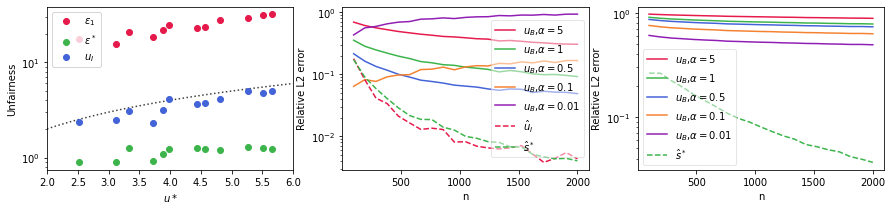

In [25]:
possible_colors=['#e6194b','#3cb44b','#4363d8','#f58231','#911eb4','#46f0f0','#fabebe','#e6beff','#fffac8', '#800000']

fig=plt.figure(figsize=(15,3))

ax=fig.add_subplot(131)

ax.scatter(true_ufi_mat,true_ufi_ind_mat+2*np.sqrt(2)*true_s_star_mat/np.sqrt(delta),color=possible_colors[0],label=r"$\epsilon_1$")
ax.scatter(true_ufi_mat,true_u_quantile_mat,color=possible_colors[1],label=r"$\epsilon^*$")
ax.scatter(true_ufi_mat,true_ufi_ind_mat,color=possible_colors[2],label=r"$u_{I}$")

ax.legend()

ax.plot(np.linspace(2,6,100), np.linspace(2,6,100), alpha=0.75, zorder=0,linestyle=":",color="black")
ax.set_xlim(left=2,right=6)
ax.set_xlabel(r"$u*$")
ax.set_ylabel("Unfairness")
ax.set_yscale("log")

ax=fig.add_subplot(132)

for i in range(len(alpha_range)): 
    ax.plot(sample_range,ufi_error.mean(axis=(0,3))[:,i],color=possible_colors[i],label=r"$u_B$,$\alpha=$"+str(alpha_range[i]))
ax.plot(sample_range,ufi_ind_error.mean(axis=(0,2)),linestyle="--",label=r"$\hat{u}_{I}$",color=possible_colors[0])
ax.plot(sample_range,s_star_error.mean(axis=(0,2)),linestyle="--",label=r"$\hat{s}^*$",color=possible_colors[1])
ax.set_yscale("log")
ax.set_xlabel("n")
ax.set_ylabel("Relative L2 error")
ax.legend(framealpha=0.5)

ax=fig.add_subplot(133)

for i in range(len(alpha_range)): 
    ax.plot(sample_range,ufi_error_synth.mean(axis=(0,3))[:,i],color=possible_colors[i],label=r"$u_B$,$\alpha=$"+str(alpha_range[i]))
ax.plot(sample_range,s_star_error_synth.mean(axis=(0,2)),linestyle="--",label=r"$\hat{s}^*$",color=possible_colors[1])
ax.set_yscale("log")
ax.set_xlabel("n")
ax.set_ylabel("Relative L2 error")
ax.legend(framealpha=0.5)

plt.show()

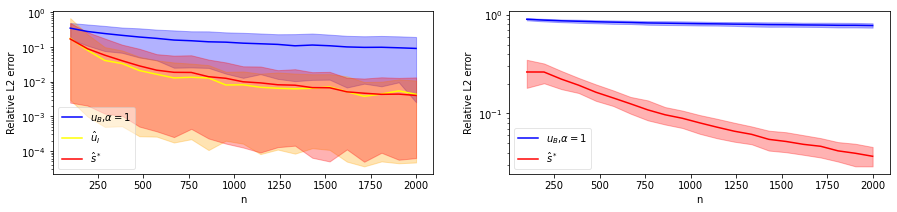

In [26]:
fig=plt.figure(figsize=(15,3))

ax=fig.add_subplot(121)

ax.plot(sample_range,ufi_error.mean(axis=(0,3))[:,1],color="blue",label=r"$u_B$,$\alpha=$"+str(alpha_range[1]))
ax.fill_between(sample_range,np.quantile(ufi_error,0.1,axis=(0,3))[:,1],np.quantile(ufi_error,0.9,axis=(0,3))[:,1],color="blue",alpha=0.3)
ax.plot(sample_range,ufi_ind_error.mean(axis=(0,2)),label=r"$\hat{u}_{I}$",color="yellow")
ax.fill_between(sample_range,np.quantile(ufi_ind_error,0.1,axis=(0,2)),np.quantile(ufi_ind_error,0.9,axis=(0,2)),color="orange",alpha=0.3)
ax.plot(sample_range,s_star_error.mean(axis=(0,2)),label=r"$\hat{s}^*$",color="red")
ax.fill_between(sample_range,np.quantile(s_star_error,0.1,axis=(0,2)),np.quantile(s_star_error,0.9,axis=(0,2)),color="red",alpha=0.3)
ax.set_yscale("log")
ax.set_xlabel("n")
ax.set_ylabel("Relative L2 error")
ax.legend(framealpha=0.5)

ax=fig.add_subplot(122)

ax.plot(sample_range,ufi_error_synth.mean(axis=(0,3))[:,1],color="blue",label=r"$u_B$,$\alpha=$"+str(alpha_range[1]))
ax.fill_between(sample_range,np.quantile(ufi_error_synth,0.1,axis=(0,3))[:,1],np.quantile(ufi_error_synth,0.9,axis=(0,3))[:,1],color="blue",alpha=0.3)
ax.plot(sample_range,s_star_error_synth.mean(axis=(0,2)),color="red",label=r"$\hat{s}^*$")
ax.fill_between(sample_range,np.quantile(s_star_error_synth,0.1,axis=(0,2)),np.quantile(s_star_error_synth,0.9,axis=(0,2)),color="red",alpha=0.3)
ax.set_yscale("log")
ax.set_xlabel("n")
ax.set_ylabel("Relative L2 error")
ax.legend(framealpha=0.5)

plt.show()

# Effect of using partitions

In [ ]:
rep_sampling=20
sample_range=np.linspace(100,2000,21)
min_ng_range=[1,10,30]
alpha_range=[5,1,0.5,0.1,0.01]

nb_vars=len(vars_to_use)

s_star_mat=np.zeros((nb_vars,len(sample_range),rep_sampling))
ufi_mat=np.zeros((nb_vars,len(sample_range),len(alpha_range),rep_sampling))

true_ufi_mat=np.zeros(nb_vars)
true_s_star_mat=np.zeros(nb_vars)

s_star_part_mat=np.zeros((nb_vars,len(sample_range),len(min_ng_range),rep_sampling))
ufi_part_mat=np.zeros((nb_vars,len(sample_range),len(min_ng_range),rep_sampling))

for k in range(nb_vars):
    var=vars_to_use[k]
    print("Computing for subset:",var)

    A=A_df.iloc[:,var]
    singleton_partition=[[i] for i in range(len(var))]

    true_s_star=compute_s_star(A,Z,singleton_partition)
    true_ufi=intersectional_unfairness(A,Z,alpha=0)

    true_ufi_mat[k]=true_ufi
    true_s_star_mat[k]=true_s_star

    for i in range(len(sample_range)):

        sample_size=int(sample_range[i])

        for j in range(rep_sampling):

            A_sample=A.sample(sample_size)
            Z_sample=Z[A_sample.index]
            A_sample=np.array(A_sample)

            s_star=compute_s_star(A_sample,Z_sample,singleton_partition)

            s_star_mat[k,i,j]=s_star

            for t in range(len(alpha_range)):

                alpha=alpha_range[t]

                ufi=intersectional_unfairness(A_sample,Z_sample,alpha=alpha)

                ufi_mat[k,i,t,j]=ufi

            for t in range(len(min_ng_range)):

                min_ng_marg=min_ng_range[t]
                
                #Computation of the partition q* for this sample
                best_part=greedy_part(A_sample,Z_sample,min_ng_marg)
                
                #This verification is to ensure that the base marginals 
                #when considering the very low number of 
                #samples (usually around n=200 or n=300) can compute without any issues
                #4 is the number of unique values necessary for no problem to happen 
                #as we considered binary protected attributes and labels 
                alpha_safe=0
                for col in A_sample.T:
                    if (np.unique(np.array([col,Z_sample]),axis=1).shape[1]<4):
                        alpha_safe=1

                ufi_part=ufi_ind_func(A_sample,Z_sample,best_part,alpha=alpha_safe)
                s_star_part=compute_s_star(A_sample,Z_sample,best_part)

                ufi_part_mat[k,i,t,j]=ufi_part

                s_star_part_mat[k,i,t,j]=s_star_part

ufi_error=np.power((ufi_mat.T-true_ufi_mat)/true_ufi_mat,2).T
s_star_error=np.power((s_star_mat.T-true_s_star_mat)/true_s_star_mat,2).T                
ufi_part_error=np.power((ufi_part_mat.T-true_ufi_mat)/true_ufi_mat,2).T

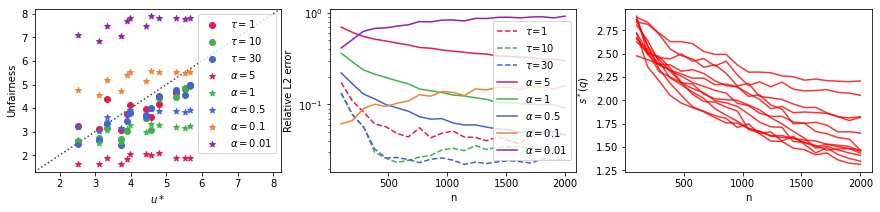

In [30]:
fig=plt.figure(figsize=(15,3))
ax=fig.add_subplot(131)

for i in range(len(min_ng_range)):
    ax.scatter(true_ufi_mat,ufi_part_mat.mean(axis=3)[:,-1,i],marker="o"\
                   ,color=possible_colors[i],label=r"$\tau=$"+str(min_ng_range[i]))
    
for i in range(len(alpha_range)):
    ax.scatter(true_ufi_mat,ufi_mat.mean(axis=3)[:,-1,i]\
                   ,color=possible_colors[i],label=r"$\alpha=$"+str(alpha_range[i]),marker="*")

ax.legend()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]

ax.plot(lims, lims, alpha=0.75, zorder=0,linestyle=":",color="black")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel(r"$u*$")
ax.set_ylabel("Unfairness")

ax=fig.add_subplot(132)

for i in range(len(min_ng_range)):
    ax.plot(sample_range,ufi_part_error.mean(axis=(0,3))[:,i]\
                   ,color=possible_colors[i],label=r"$\tau\!=\!$"+str(min_ng_range[i]),linestyle="--")
    
for i in range(len(alpha_range)):
    ax.plot(sample_range,ufi_error.mean(axis=(0,3))[:,i]\
                   ,color=possible_colors[i],label=r"$\alpha=$"+str(alpha_range[i]))
    
ax.set_yscale("log")
ax.set_xlabel("n")
ax.set_ylabel("Relative L2 error")
ax.legend()

ax=fig.add_subplot(133)
ax.set_xlabel("n")
ax.set_ylabel(r"$s^*(q)$")

ax.plot(sample_range,s_star_part_mat.mean(axis=3)[:,:,1].T,color="red",alpha=0.8)

plt.show()

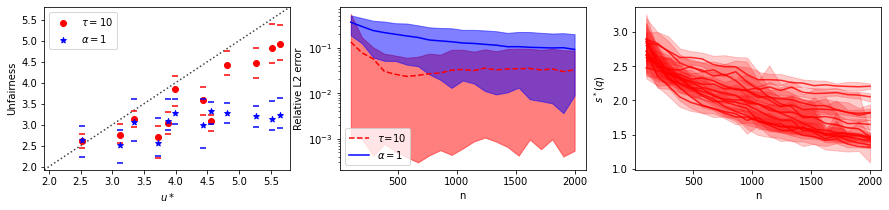

In [31]:
fig=plt.figure(figsize=(15,3))
ax=fig.add_subplot(131)

ax.scatter(true_ufi_mat,ufi_part_mat.mean(axis=3)[:,-1,1],marker="o"\
               ,color="red",label=r"$\tau=$"+str(min_ng_range[1]))

ax.scatter(true_ufi_mat,np.quantile(ufi_part_mat,0.1,axis=3)[:,-1,1],marker="_"\
               ,color="red")

ax.scatter(true_ufi_mat,np.quantile(ufi_part_mat,0.9,axis=3)[:,-1,1],marker="_"\
               ,color="red")

ax.scatter(true_ufi_mat,ufi_mat.mean(axis=3)[:,-1,1]\
               ,color="blue",label=r"$\alpha=$"+str(alpha_range[1]),marker="*")

ax.scatter(true_ufi_mat,np.quantile(ufi_mat,0.1,axis=3)[:,-1,1],marker="_"\
               ,color="blue")

ax.scatter(true_ufi_mat,np.quantile(ufi_mat,0.9,axis=3)[:,-1,1],marker="_"\
               ,color="blue")

ax.legend()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]), 
    np.max([ax.get_xlim(), ax.get_ylim()]), 
]

ax.plot(lims, lims, alpha=0.75, zorder=0,linestyle=":",color="black")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel(r"$u*$")
ax.set_ylabel("Unfairness")

ax=fig.add_subplot(132)

ax.plot(sample_range,ufi_part_error.mean(axis=(0,3))[:,1]\
               ,color="red",label=r"$\tau\!=\!$"+str(min_ng_range[1]),linestyle="--")

ax.fill_between(sample_range,np.quantile(ufi_part_error,0.1,axis=(0,3))[:,1],\
                np.quantile(ufi_part_error,0.9,axis=(0,3))[:,1],alpha=0.5,color="red")

ax.plot(sample_range,ufi_error.mean(axis=(0,3))[:,1]\
               ,color="blue",label=r"$\alpha=$"+str(alpha_range[1]))

ax.fill_between(sample_range,np.quantile(ufi_error,0.1,axis=(0,3))[:,1]\
                ,np.quantile(ufi_error,0.9,axis=(0,3))[:,1],alpha=0.5,color="blue")



ax.set_yscale("log")
ax.set_xlabel("n")
ax.set_ylabel("Relative L2 error")
ax.legend()

ax=fig.add_subplot(133)
ax.set_xlabel("n")
ax.set_ylabel(r"$s^*(q)$")

ax.plot(sample_range,s_star_part_mat.mean(axis=3)[:,:,1].T,color="red",alpha=0.8)

for i in range(nb_vars):
    ax.fill_between(sample_range,np.quantile(s_star_part_mat,0.1,axis=3)[i,:,1].T\
                    ,np.quantile(s_star_part_mat,0.9,axis=3)[i,:,1].T,color="red",alpha=0.2)

plt.show()

# Convergence comparison of $\inf_{g(\lambda)\leq 0} (\lambda^+-\lambda^-)$

In [ ]:
#Note that some numerical errors may happen during the computation of the constraint g

delta=0.1

true_chernoff_mat=np.zeros(nb_vars)
true_ufi_mat=np.zeros(nb_vars)
true_s_star_mat=np.zeros(nb_vars)

sample_range_chernoff=[1000,2000,3000,5000,10000]
rep_sampling_chernoff=10

chernoff_mat=np.zeros((nb_vars,len(sample_range_chernoff),rep_sampling_chernoff))
ufi_mat=np.zeros((nb_vars,len(sample_range_chernoff),rep_sampling_chernoff))
s_star_mat=np.zeros((nb_vars,len(sample_range_chernoff),rep_sampling_chernoff))

for k in range(nb_vars):
    
    var=vars_to_use[k]
    
    print("Computing for subset:",var)

    A=A_df.iloc[:,var]
    singleton_partition=[[i] for i in range(len(var))]

    true_ufi=intersectional_unfairness(A,Z,alpha=0)
    true_chernoff=compute_chernoff_bound(A,Z,singleton_partition,delta)
    true_s_star=compute_s_star(A,Z,singleton_partition)
    
    true_ufi_mat[k]=true_ufi
    true_chernoff_mat[k]=true_chernoff
    true_s_star_mat[k]=true_s_star
        
    for i in range(len(sample_range_chernoff)):

        sample_size=int(sample_range_chernoff[i])

        for j in range(rep_sampling_chernoff):

            A_sample=A.sample(sample_size)
            Z_sample=Z[A_sample.index]
            A_sample=np.array(A_sample)
            
            chernoff_term=compute_chernoff_bound(A_sample,Z_sample,singleton_partition,delta)
            ufi=intersectional_unfairness(A_sample,Z_sample,alpha=1)
            s_star=compute_s_star(A_sample,Z_sample,singleton_partition)
            
            ufi_mat[k,i,j]=ufi
            s_star_mat[k,i,j]=s_star
            if chernoff_term<30:
                chernoff_mat[k,i,j]=chernoff_term
            else: 
                chernoff_mat[k,i,j]=np.nan

ufi_error=np.power((ufi_mat.T-true_ufi_mat)/true_ufi_mat,2).T
s_star_error=np.power((s_star_mat.T-true_s_star_mat)/true_s_star_mat,2).T
chernoff_error=np.power((chernoff_mat.T-true_chernoff_mat)/true_chernoff_mat,2).T

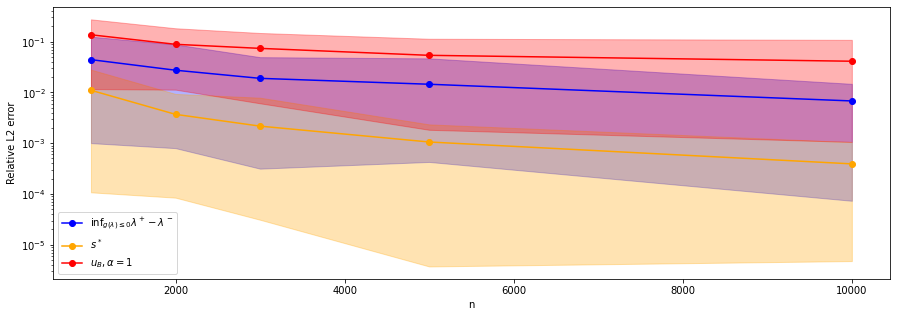

In [44]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(111)

ax.plot(sample_range_chernoff,np.nanmean(chernoff_error,axis=(0,2)),label=r"$\inf_{g(\lambda)\leq 0} \lambda^+ -\lambda^-$"\
            ,color="blue",marker="o")
ax.fill_between(sample_range_chernoff,np.quantile(chernoff_error,0.1,axis=(0,2))\
                ,np.quantile(chernoff_error,0.9,axis=(0,2)),alpha=0.3,color="blue")

ax.plot(sample_range_chernoff,s_star_error.mean(axis=(0,2)),marker="o",label=r"$s^*$"\
            ,color="orange")
ax.fill_between(sample_range_chernoff,np.quantile(s_star_error,0.1,axis=(0,2))\
                ,np.quantile(s_star_error,0.9,axis=(0,2)),alpha=0.3,color="orange")

ax.plot(sample_range_chernoff,ufi_error.mean(axis=(0,2)),marker="o",label=r"$u_B,\alpha=1$"\
            ,color="red")
ax.fill_between(sample_range_chernoff,np.quantile(ufi_error,0.1,axis=(0,2))\
                ,np.quantile(ufi_error,0.9,axis=(0,2)),alpha=0.3,color="red")

ax.set_yscale("log")

ax.legend()
ax.set_xlabel("n")
ax.set_ylabel("Relative L2 error")

plt.show()

# Comparison of various bounds with and without partitions

In [ ]:
delta=0.1
min_ng_marg=10

sample_size_part=2000
rep_sampling_part=1

chebyshev_bound_1_mat=np.zeros(nb_vars)
chebyshev_bound_2_mat=np.zeros(nb_vars)
chernoff_bound_mat=np.zeros(nb_vars)

chebyshev_bound_1_part_mat=np.zeros((nb_vars,rep_sampling_part))
chebyshev_bound_2_part_mat=np.zeros((nb_vars,rep_sampling_part))
chernoff_bound_part_mat=np.zeros((nb_vars,rep_sampling_part))

true_ufi_mat=np.zeros(nb_vars)
true_ufi_quantile_mat=np.zeros(nb_vars)

for k in range(nb_vars):
    var=vars_to_use[k]
    print("Computing for subset:",var)

    A=A_df.iloc[:,var]
    singleton_partition=[[i] for i in range(len(var))]

    true_ufi=intersectional_unfairness(A,Z,alpha=0)
    true_ufi_quantile=intersectional_unfairness_quantile(A,Z,alpha=0,delta=delta)

    true_ufi_mat[k]=true_ufi
    true_ufi_quantile_mat[k]=true_ufi_quantile
    
    chebyshev_bound_1=compute_chebyshev_bound_1(A,Z,singleton_partition,delta)
    chebyshev_bound_2=compute_chebyshev_bound_2(A,Z,singleton_partition,delta)
    chernoff_bound=compute_chernoff_bound(A,Z,singleton_partition,delta,return_bound=True)
    
    chebyshev_bound_1_mat[k]=chebyshev_bound_1
    chebyshev_bound_2_mat[k]=chebyshev_bound_2
    chernoff_bound_mat[k]=chernoff_bound

    for i in range(rep_sampling_part):

        A_sample=A.sample(sample_size)
        Z_sample=Z[A_sample.index]
        A_sample=np.array(A_sample)
        
        #Here note that the partition is computed on a sample of A
        best_part=greedy_part(A_sample,Z_sample,min_ng_marg)
        
        #But here we compute the statistical quantities on the whole A!
        #We only wish to look at the asymptotic values of these bounds when helped with a partition
        #but if we also generate the partitions on the whole dataset
        #this will logically yield the coarsest partition resulting in s*=0
        chebyshev_bound_1_part=compute_chebyshev_bound_1(A,Z,best_part,delta)
        chebyshev_bound_2_part=compute_chebyshev_bound_2(A,Z,best_part,delta)
        chernoff_bound_part=compute_chernoff_bound(A,Z,best_part,delta,return_bound=True)

        chebyshev_bound_1_part_mat[k]=chebyshev_bound_1_part
        chebyshev_bound_2_part_mat[k]=chebyshev_bound_2_part
        chernoff_bound_part_mat[k]=chernoff_bound_part

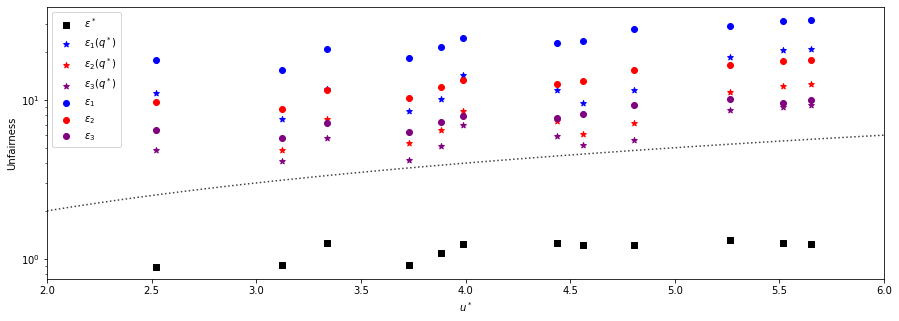

In [52]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)

ax.scatter(true_ufi_mat,true_ufi_quantile_mat,marker="s",label=r"$\epsilon^*$",color="black")

ax.scatter(true_ufi_mat,chebyshev_bound_1_part_mat.mean(axis=1),marker="*",color="blue",label=r"$\epsilon_1(q^*)$")
ax.scatter(true_ufi_mat,chebyshev_bound_2_part_mat.mean(axis=1),marker="*",color="red",label=r"$\epsilon_2(q^*)$")
ax.scatter(true_ufi_mat,chernoff_bound_part_mat.mean(axis=1),marker="*",color="purple",label=r"$\epsilon_3(q^*)$")

ax.scatter(true_ufi_mat,chebyshev_bound_1_mat,marker="o",color="blue",label=r"$\epsilon_1$")
ax.scatter(true_ufi_mat,chebyshev_bound_2_mat,marker="o",color="red",label=r"$\epsilon_2$")
ax.scatter(true_ufi_mat,chernoff_bound_mat,marker="o",color="purple",label=r"$\epsilon_3$")
ax.set_yscale("log")

ax.legend()


ax.plot(np.linspace(2,6,100), np.linspace(2,6,100), alpha=0.75, zorder=0,linestyle=":",color="black")
ax.set_xlim(left=2,right=6)

ax.set_xlabel(r"$u^*$")
ax.set_ylabel("Unfairness")

plt.show()

# Brief experiment on Probabilistic Unfairness for $(\hat{Y},A)$ continuous.

In [55]:
n_protected=10

#Generate a random covariance matrix
W=scipy.stats.wishart.rvs(n_protected+1,np.diag(np.ones(n_protected+1)))
WA=W[1:,1:]
WZ=W[0,0]
WAZ=W[0,1:].reshape((-1,1))

def mu_cond_z_a(a):
    return WAZ.T@np.linalg.inv(WA)@a

def mu_cond_a_z(z):
    return WAZ*z/WZ

WZ_A=(WZ-WAZ.T@np.linalg.inv(WA)@WAZ).flatten()
WA_Z=WA-WAZ@WAZ.T/WZ

n_monte_carlo=10000
epsi_range=np.linspace(0.5,6,15)

prob_unfairness=[]

for epsi in epsi_range:
    monte_carlo_mean=0
    for i in range(n_monte_carlo):
        var_z=scipy.stats.multivariate_normal.rvs(0,WZ)
        var_a=scipy.stats.multivariate_normal.rvs(mu_cond_a_z(var_z).flatten(),WA_Z,2)
        f_1=scipy.stats.multivariate_normal.pdf(var_z,mu_cond_z_a(var_a[0]),WZ_A.flatten())
        f_2=scipy.stats.multivariate_normal.pdf(var_z,mu_cond_z_a(var_a[1]),WZ_A.flatten())

        if np.abs(np.log(f_1/f_2))>epsi:
            monte_carlo_mean+=1

    monte_carlo_mean=monte_carlo_mean/n_monte_carlo
    prob_unfairness.append(monte_carlo_mean)

In [56]:
W=0.5*np.ones((n_protected,n_protected))+0.5*np.eye(n_protected)
WA=W[1:,1:]
WZ=W[0,0]
WAZ=W[0,1:].reshape((-1,1))

def mu_cond_z_a(a):
    return WAZ.T@np.linalg.inv(WA)@a

def mu_cond_a_z(z):
    return WAZ*z/WZ

WZ_A=(WZ-WAZ.T@np.linalg.inv(WA)@WAZ).flatten()
WA_Z=WA-WAZ@WAZ.T/WZ

n_monte_carlo=10000
epsi_range=np.linspace(0.5,6,15)

prob_unfairness_2=[]

for epsi in epsi_range:
    monte_carlo_mean=0
    for i in range(n_monte_carlo):
        var_z=scipy.stats.multivariate_normal.rvs(0,WZ)
        var_a=scipy.stats.multivariate_normal.rvs(mu_cond_a_z(var_z).flatten(),WA_Z,2)
        f_1=scipy.stats.multivariate_normal.pdf(var_z,mu_cond_z_a(var_a[0]),WZ_A.flatten())
        f_2=scipy.stats.multivariate_normal.pdf(var_z,mu_cond_z_a(var_a[1]),WZ_A.flatten())

        if np.abs(np.log(f_1/f_2))>epsi:
            monte_carlo_mean+=1

    monte_carlo_mean=monte_carlo_mean/n_monte_carlo
    prob_unfairness_2.append(monte_carlo_mean)

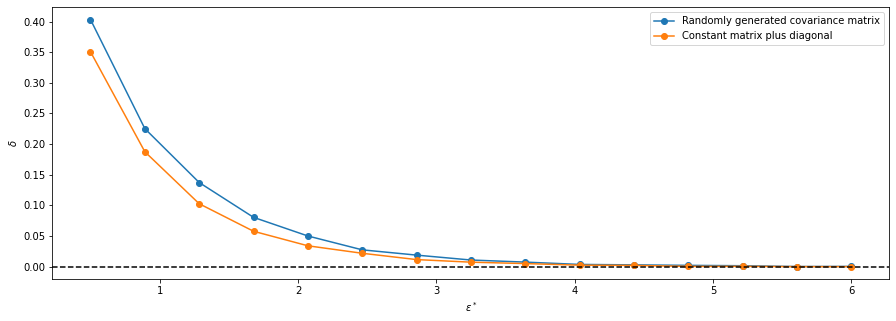

In [57]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)

ax.plot(epsi_range,prob_unfairness,label="Randomly generated covariance matrix",marker="o")
ax.plot(epsi_range,prob_unfairness_2,label="Constant matrix plus diagonal",marker="o")
ax.set_xlabel(r"$\epsilon^*$")
ax.set_ylabel(r"$\delta$")
ax.axhline(0,color="black",linestyle="--")
ax.legend()

plt.show()